# Using VGG for Emotion Detection

### Training Emotion Detector

In [0]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.getcwd()
num_classes = 2
img_rows, img_cols = 48, 48
batch_size = 16

train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Himirror_dataset/binarydata/train'
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Himirror_dataset/binarydata/valid'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Our Keras Imports

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

## Keras LittleVGG Model

In [0]:
#drop_pram = 0.5
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(drop_pram))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(drop_pram))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(drop_pram))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(drop_pram))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.2))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.2))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
#model.add(Activation("softmax"))
model.add(Activation("sigmoid"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)       

## Training our model

In [0]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                     
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/Colab Notebooks/emotion_little_vgg_cal_binary.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

patience_num = 5
earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = patience_num,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = patience_num - 2, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]
# We use a very small learning rate 
#model.compile(loss = 'categorical_crossentropy',
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 2000
nb_validation_samples = 600
epochs = 50

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 7s 56ms/step - loss: 0.6548 - accuracy: 0.6166 - val_loss: 2.4166 - val_accuracy: 0.5507

Epoch 00001: val_accuracy improved from -inf to 0.55068, saving model to /content/gdrive/My Drive/Colab Notebooks/emotion_little_vgg_cal_binary.h5
Epoch 2/50
125/125 [==============================] - 5s 44ms/step - loss: 0.6408 - accuracy: 0.6355 - val_loss: 0.4545 - val_accuracy: 0.7217

Epoch 00002: val_accuracy improved from 0.55068 to 0.72175, saving model to /content/gdrive/My Drive/Colab Notebooks/emotion_little_vgg_cal_binary.h5
Epoch 3/50
125/125 [==============================] - 5s 43ms/step - loss: 0.6161 - accuracy: 0.6619 - val_loss: 0.2510 - val_accuracy: 0.7149

Epoch 00003: val_accuracy did not improve from 0.72175
Epoch 4/50
125/125 [==============================] - 5s 44ms/step - loss: 0.6093 - accuracy: 0.6621 - val_loss: 0.5622 - val_accuracy: 0.7688

Epoch 00004: val_accuracy improved from 0.72175 to 0.76884, saving model

### Loading our saved model

In [0]:
from keras.models import load_model
import tensorflow as tf
classifier = load_model('/content/gdrive/My Drive/Colab Notebooks/emotion_little_vgg_cal_binary.h5')
#new_model= tf.keras.models.load_model(filepath="/content/gdrive/My Drive/Colab Notebooks/emotion_little_vgg_cal_binary.h5")
#tflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
#tflite_model = tflite_converter.convert()
#open("/content/gdrive/My Drive/Colab Notebooks/emotion_binary.tflite", "wb").write(tflite_model)

In [0]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_validation_samples = 600
# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

Found 600 images belonging to 2 classes.


Confusion Matrix
[[259  41]
 [ 16 284]]
Classification Report
              precision    recall  f1-score   support

       Happy       0.94      0.86      0.90       300
     Unhappy       0.87      0.95      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.90       600
weighted avg       0.91      0.91      0.90       600



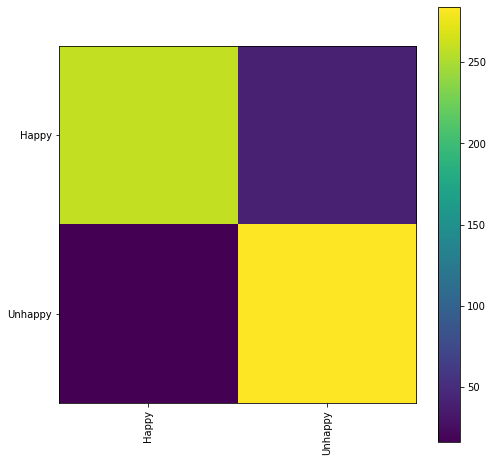

In [0]:
#Confution Matrix and Classification Report
Y_pred = classifier.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


File Name : /content/gdrive/My Drive/Colab Notebooks/Himirror_dataset/binarydata/valid/Happy/7047.jpg
Predict : Happy
True : Happy
[[0.95698315 0.04850028]]


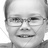

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from IPython.display import Image

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 1):
    path = "/content/gdrive/My Drive/Colab Notebooks/Himirror_dataset/binarydata/valid/"  
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images)
    predictions.append(classes)
    print("File Name : " + final_path)
    print("Predict : " + class_labels[predictions[i][0]])
    print("True : " + true_labels[i])
    print(classifier.predict(images))    
Image(filename = final_path )